# Quickly visualize the distributions of a generated ToyBrain data:

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
# standard python packages
import os, sys
from glob import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
import matplotlib.image as mpimg
from sklearn import datasets, linear_model
from tqdm.notebook import tqdm
import random
import math
import json

from helper.viz_helpers import *

## Visualize current generative parameters and their distributions

## Generate data
with debug switch on

In [155]:
! python create_toybrains.py -d -n 1000

Generative parameter        |        States 
------------------------------------------------------------
brain_vol-radminor         [20 21 22 23 24]
brain_vol-radmajor         [26 27 28 29 30]
brain_thick                [1 2 3 4]
brain_int                  [210 200 190 180 170]
border_int                 ['0-mediumslateblue' '1-slateblue' '2-darkslateblue' '3-darkblue']
vent_thick                 [1 2 3 4]
shape-top_curv             [ 3  4  5  6  7  8  9 10 11]
shape-top_int              ['0-indianred' '1-salmon' '2-lightsalmon' '3-palegoldenrod' '4-lightgreen'
 '5-darkgreen']
shape-top_vol-rad          [2 3 4 5]
shape-midr_curv            [ 3  4  5  6  7  8  9 10 11]
shape-midr_int             ['0-indianred' '1-salmon' '2-lightsalmon' '3-palegoldenrod' '4-lightgreen'
 '5-darkgreen']
shape-midr_vol-rad         [2 3 4 5]
shape-midl_curv            [ 3  4  5  6  7  8  9 10 11]
shape-midl_int             ['0-indianred' '1-salmon' '2-lightsalmon' '3-palegoldenrod' '4-lightgreen'
 '5-darkg

In [4]:
DATA_DIR = "toybrains" #"toybrains10k"
df = pd.read_csv(glob(f"{DATA_DIR}/toybrains_n*.csv")[0]).set_index('subjectID')

## Visualize generated images

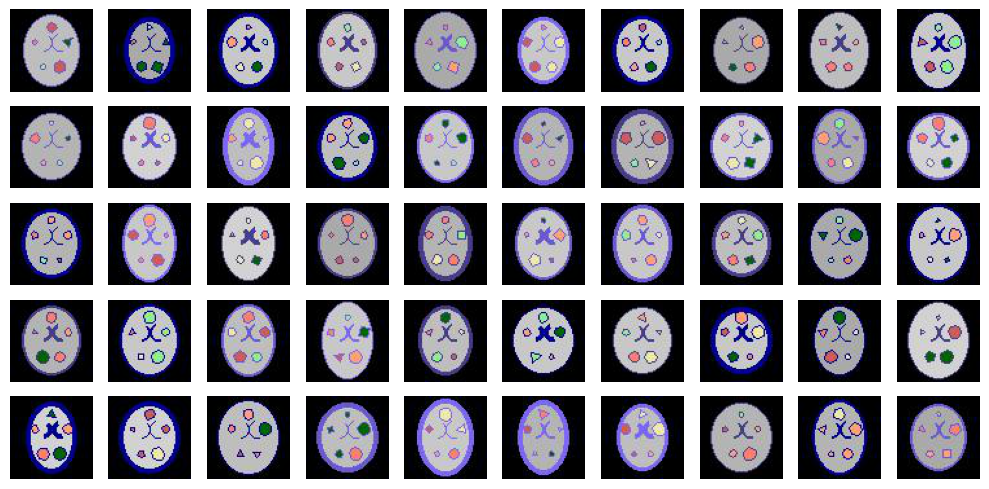

In [159]:
img_files = sorted(glob(f"{DATA_DIR}/images/*.jpg"))
show_images(img_files=img_files, n_rows=5)

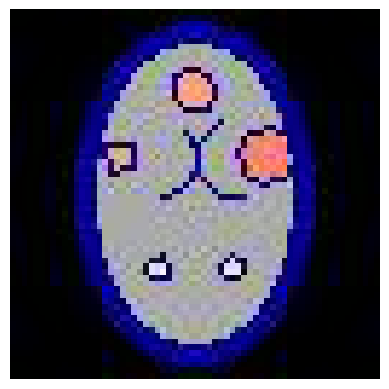

In [129]:
# one random image
img_file = np.random.choice(img_files)
img = mpimg.imread(img_file)
f = plt.figure(frameon=False)
plt.imshow(img)
plt.axis('off')
# plt.savefig("docs/brain.png", bbox_inches='tight')
plt.show()

## Visualize generated data distributions

In [160]:
# sort dataframe cols by column name
df = df.reindex(sorted(df.columns), axis=1)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1000 entries, 0 to 999
Data columns (total 34 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   _gen_brain_vol-radmajor   1000 non-null   float64
 1   _gen_brain_vol-radminor   1000 non-null   float64
 2   _gen_shape-botl_vol-rad   1000 non-null   float64
 3   _gen_shape-botr_vol-rad   1000 non-null   float64
 4   _gen_shape-midl_vol-rad   1000 non-null   float64
 5   _gen_shape-midr_vol-rad   1000 non-null   float64
 6   _gen_shape-top_vol-rad    1000 non-null   float64
 7   cov_age                   1000 non-null   float64
 8   cov_sex                   1000 non-null   object 
 9   cov_site                  1000 non-null   object 
 10  gen_border_int            1000 non-null   object 
 11  gen_brain_int             1000 non-null   float64
 12  gen_brain_thick           1000 non-null   float64
 13  gen_brain_vol             1000 non-null   float64
 14  gen_shape

#### Distribution of covariates

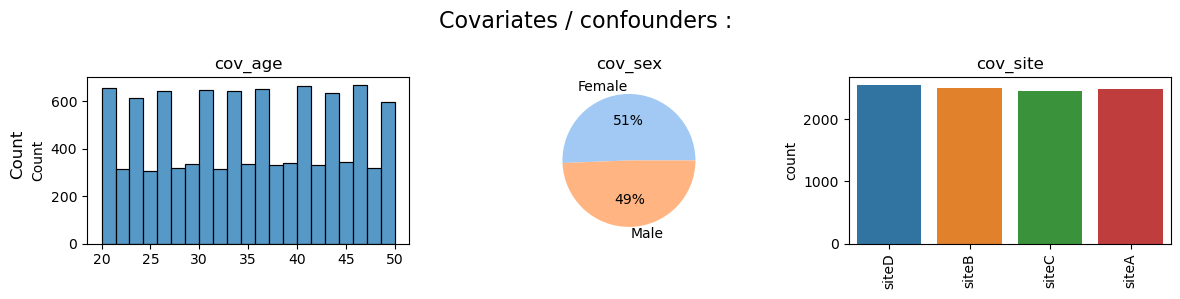

In [130]:
# get all column names starting with 'gen_'
plot_col_dists(df.filter(regex='^cov_'), title="Covariates / confounders :")
plt.show()

#### Distribution of labels

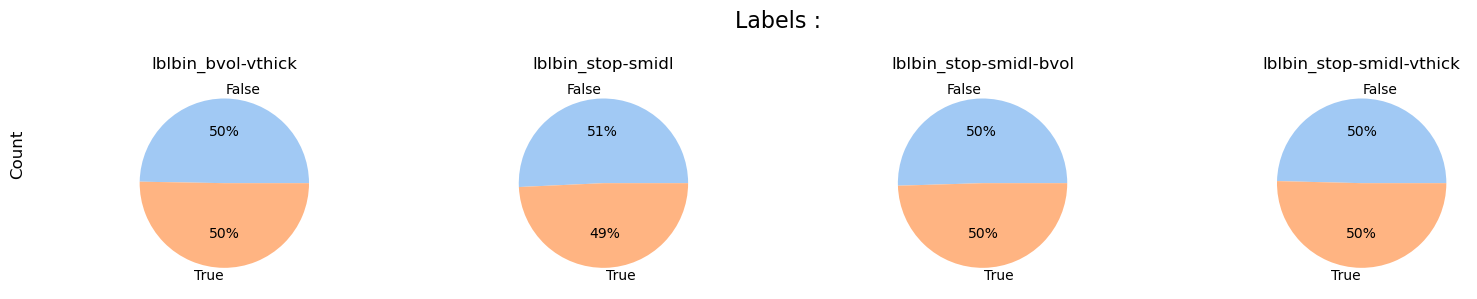

In [113]:
# get all column names starting with 'gen_'
plot_col_dists(df.filter(regex='^lbl'), title="Labels :")
plt.show()

#### Distribution of sampled generative params

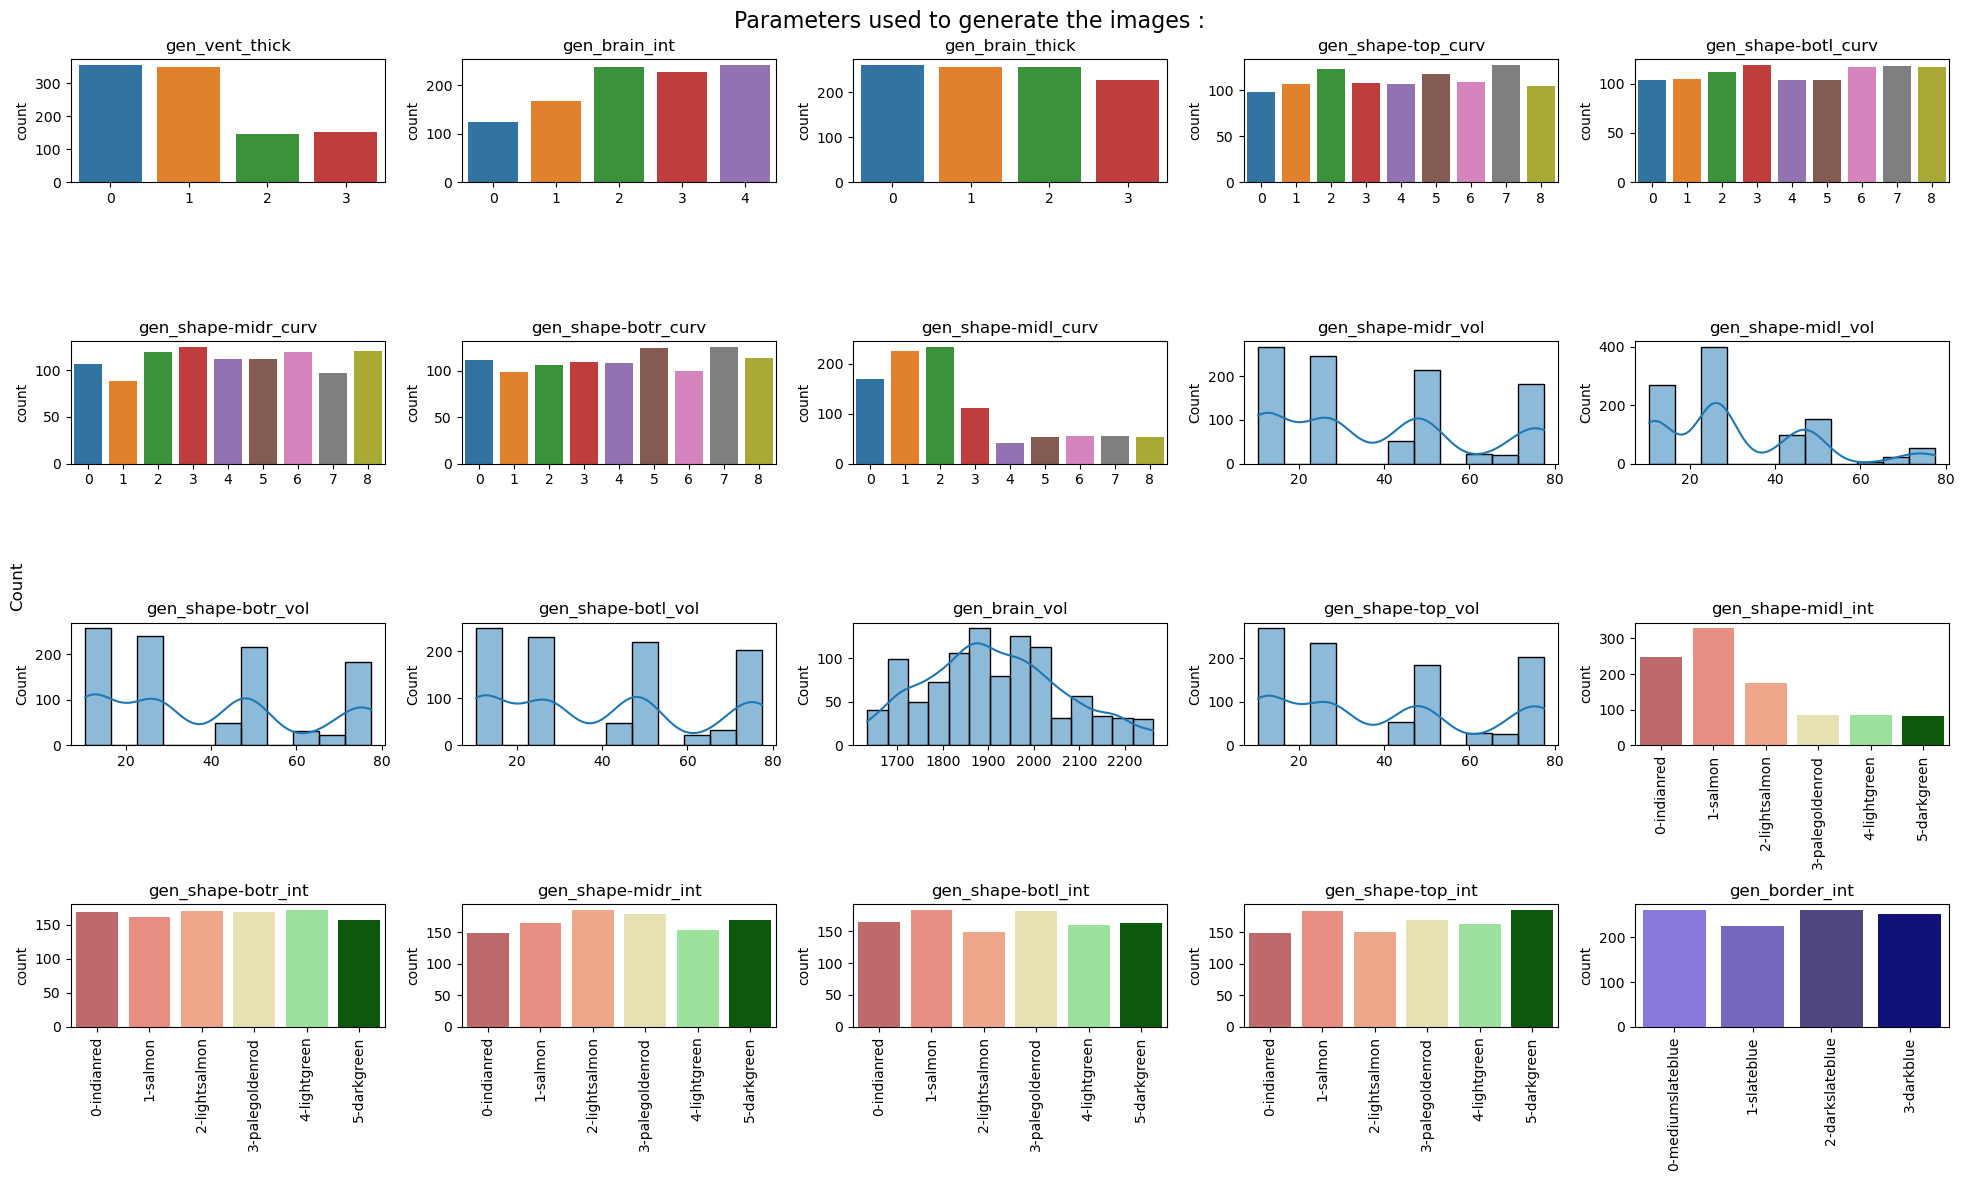

In [192]:
# get all column names starting with 'gen_'
plot_col_counts(df.filter(regex='^gen_'), title="Image generation attributes :")
plt.show()

### Plot data distribution of cov values and label groups
TODO: use hue to show different label states for the same distribution

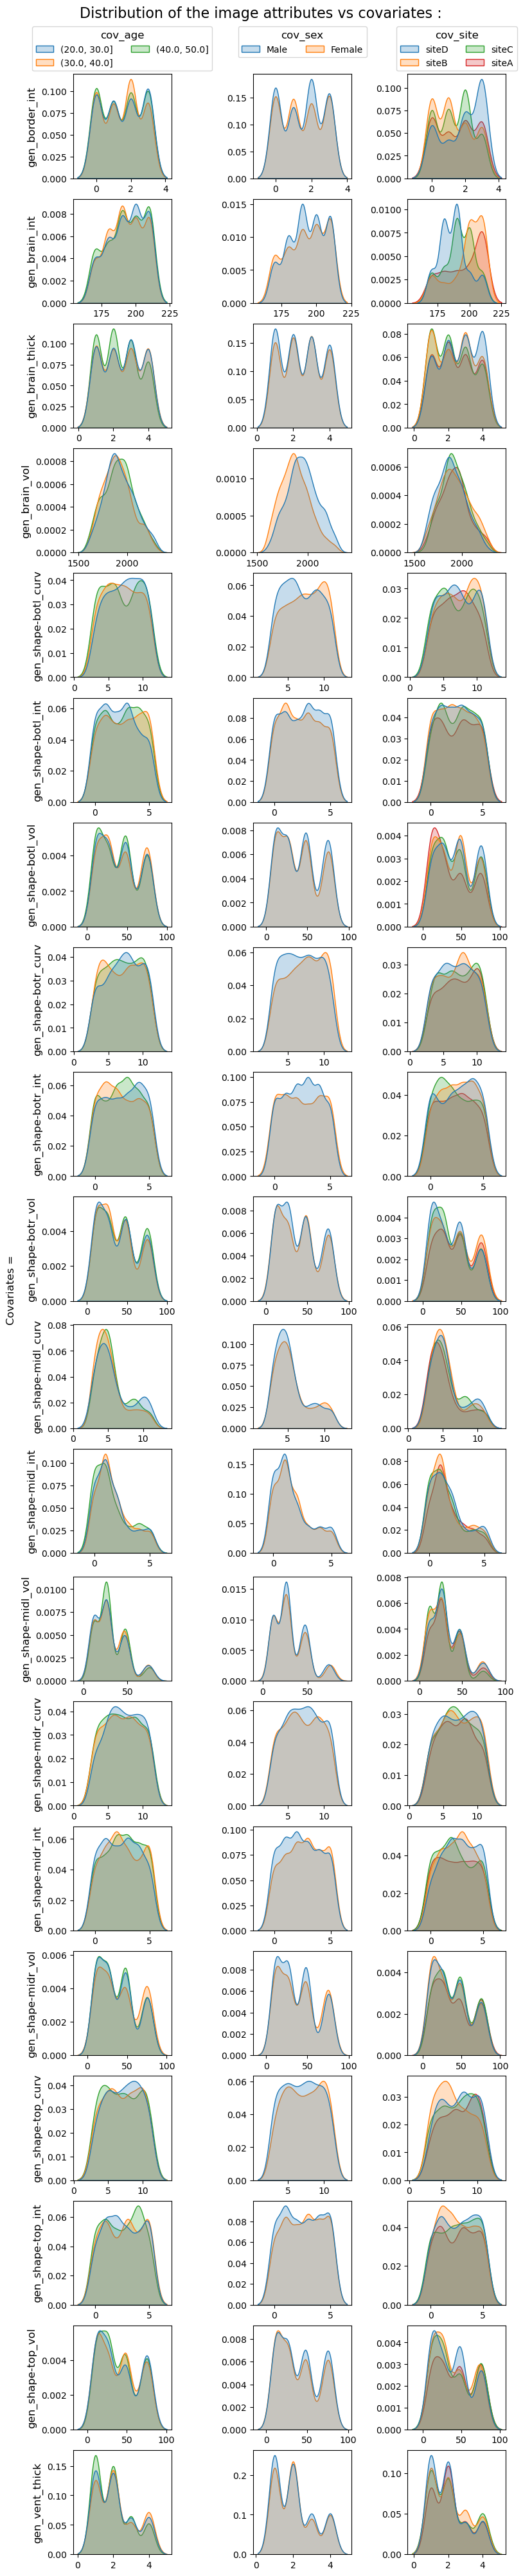

In [54]:
# get all column names starting with 'gen_'
plot_col_dists(df, attr_cols=df.filter(regex='^gen_').columns, cov_cols=df.filter(regex='^cov_').columns, 
               title="Distribution of the image attributes vs covariates :")
plt.show()

### Plot all image generation atributes

In [88]:
df = pd.read_csv(glob(f"{DATA_DIR}/toybrains_n*.csv")[0]).set_index('subjectID')

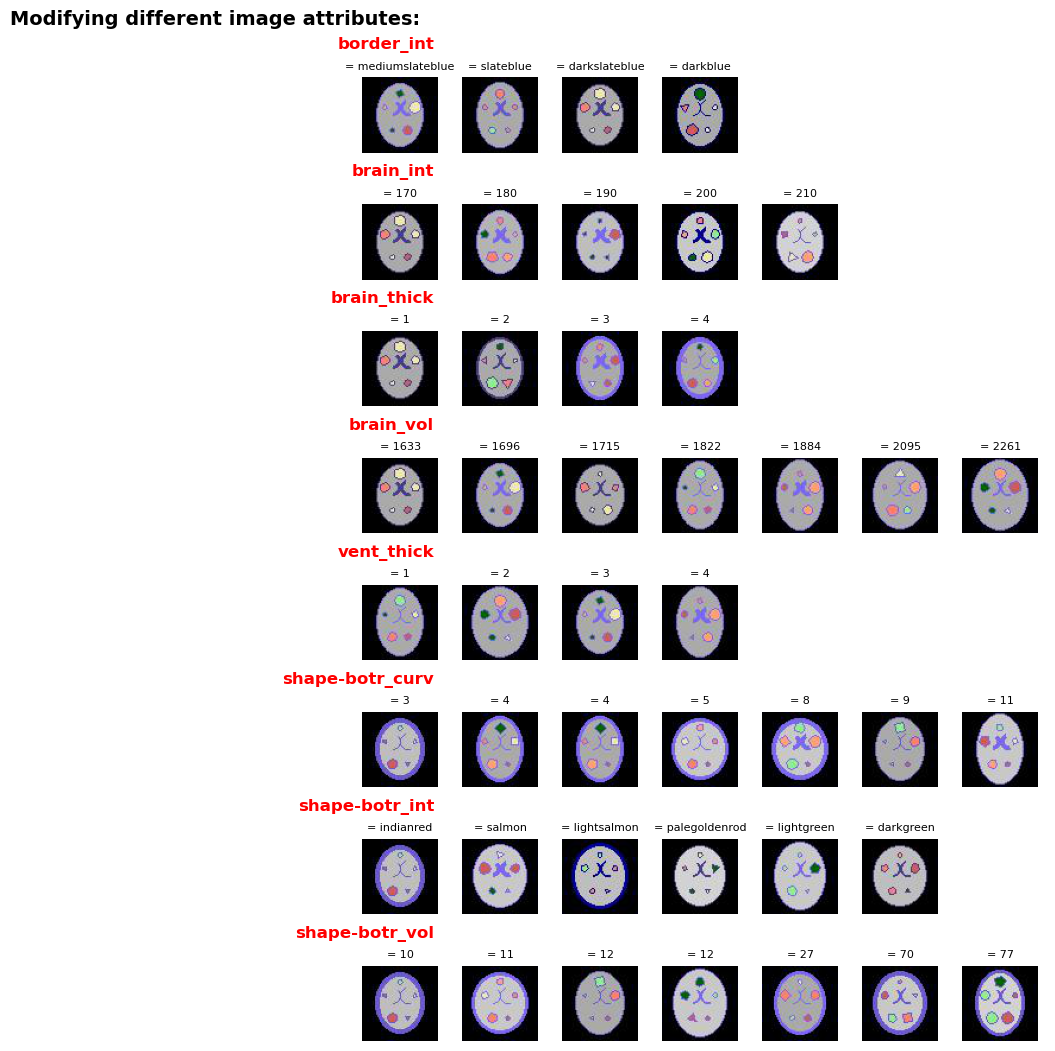

In [5]:
fs = 12
atrs = sorted([col for col in df.filter(regex='^gen_').columns if 'shape' not in col])
# drop all shapes except one to show
atrs_shape = [col for col in df.filter(regex='^gen_').columns if ('botr' in col)]
atrs = atrs + atrs_shape
# f, axes = plt.subplots(len(atrs), 1, figsize=(7,1.3*len(atrs)), constrained_layout=True)
f = plt.figure(constrained_layout=True, figsize=(7,1.3*len(atrs)))
f.suptitle(f"Modifying different image attributes:", 
           fontsize=fs+2, ha='right', x=0.1, fontweight='heavy')
# define each subplots row as a subfigure and set separate subtitles
subfigs = f.subfigures(len(atrs), 1)

for i, subfig in enumerate(subfigs):
    
    atr = atrs[i]
    atr_vals = df[atr].sort_values().unique()
    if len(atr_vals)>7: # if more than 7 then sample the least best and some values in between
        atr_vals = [atr_vals[0]] + np.sort(np.random.choice(atr_vals[1:-2], 7-2)).tolist() + [atr_vals[-1]]
    # print(atr)
    # color = 'darkred' if 'brain' in atr else ('darkgreen' if 'shape' in atr else 'darkblue')
    subfig.suptitle(atr.replace('gen_',''), 
                    fontsize=fs, color='r', ha='right', x=0.12, fontweight='heavy')
    axes_row = subfig.subplots(nrows=1, ncols=7)
    
    # organize the attribute sorting order so that  the images are similar to each other within each row
    col_order = atrs[:]
    related_atrs = [col for col in col_order if (atr.split('_')[1] in col) and (col!=atr)]
    col_order = [atr] + related_atrs + [c for c in col_order if c not in (related_atrs + [atrs])]
    df_sorted = df.sort_values(by=col_order, axis=0)
    
    for j, ax in enumerate(axes_row):
        if j<len(atr_vals):
            atr_val = atr_vals[j]
            sample = df_sorted.loc[df_sorted[atr]==atr_val].iloc[0]
            subID = f"{sample.name:05}"
            # print(subID) 
            img = mpimg.imread(f"toybrains/images/{subID}.jpg")
            ax.imshow(img)
            if isinstance(atr_val, float): atr_val = int(atr_val)
            if isinstance(atr_val, str): atr_val = atr_val.split('-')[1]
            ax.set_title(f"= {atr_val}", fontsize=fs-4, ha='center')
        
        ax.axis("off")

# plt.savefig("docs/image_attrs.png", bbox_inches='tight')
plt.show()

### TODOS:

In [ ]:
## Create the ventricles image

# from PIL import Image, ImageDraw
# S=200
# # Create a new image with a black background
# img = Image.new("RGB", (S, S), color="black")

# # Draw two arcs at the center of the image, facing opposite to each other and touching at the center
# draw = ImageDraw.Draw(img)
# x_off, y_off= 0,0
# xy_r = (S*.2, S*.2, S*.5, S*.5)
# xy_l = (S*.5, S*.2, S*.8, S*.5)
# print(xy_r, xy_l)
# draw.arc(xy_r, start=300, end=100,   fill="red",  width=8)
# draw.arc(xy_l, start=-300, end=-100, fill="blue", width=8)

# # Show the image
# img